In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from statsmodels.stats import diagnostic
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import math
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data_folder = './MovieSummaries/MovieSummaries/'
#paths to files
plot_summaries_path = data_folder + 'plot_summaries.txt'
movie_metadata_path = data_folder + 'movie.metadata.tsv'
character_metadata_path = data_folder + 'character.metadata.tsv'
role_classification_path = data_folder + 'tvtropes.clusters.txt'

# load the data
# 1. Plot summaries data
plot_summaries_df = pd.read_csv(plot_summaries_path, delimiter='\t', names=['wikipedia_movie_id', 'plot_summary'], 
                                 encoding='utf-8')

# 2. Movie metadata
movie_metadata_df = pd.read_csv(movie_metadata_path, delimiter='\t', names=['wikipedia_movie_id', 'freebase_movie_id', 
                                                                            'movie_name', 'release_date', 'box_office_revenue',
                                                                            'runtime', 'languages', 'countries', 'genres'], 
                                 encoding='utf-8')

# 3. Character metadata
character_metadata_df = pd.read_csv(character_metadata_path, delimiter='\t', names=['wikipedia_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 
                                                                                    'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                                                                                    'actor_age_at_release', 'freebase_character_actor_map_id', 'freebase_character_id', 
                                                                                    'freebase_actor_id'], 
                                     encoding='utf-8')
role_classification_df = pd.read_csv(role_classification_path, delimiter='\t', names= ['role_type', 'poubelle1'])

In [3]:
role_classification_df['character_name']= role_classification_df['poubelle1'].apply(lambda x : re.search('"char": "(.+.?)", "movie":', x).group(1) if re.search('"char": "(.+.?)", "movie":', x) else np.nan)

role_classification_df['movie_name']= role_classification_df['poubelle1'].apply(lambda x : re.search('"movie": "(.+.?)", "id":', x).group(1) if re.search('"char": "(.+.?)", "id":', x) else np.nan)

role_classification_df['freebase_movie_id']= role_classification_df['poubelle1'].apply(lambda x : re.search('"id": "(.+.?)", "actor":', x).group(1) if re.search('"id": "(.+.?)", "actor":', x) else np.nan)

role_classification_df['actor_name']= role_classification_df['poubelle1'].apply(lambda x : re.search('"actor": "(.+.?)"}', x).group(1) if re.search('"actor": "(.+.?)"}', x) else np.nan)

role_classification_df.drop(columns= 'poubelle1', inplace= True)

In [4]:
movies = pd.read_csv('ml-32m/movies.csv')

In [5]:
movie_metadata_df['movie_name_formatted'] = movie_metadata_df['movie_name'].str.lower().str.strip()
movies['title_format'] = movies['title'].str[:-6].str.strip().str.lower()
# calculate the number of common movies between the two datasets

common_movies = set(movie_metadata_df['movie_name_formatted']).intersection(set(movies['title_format']))
print('Number of common movies:', len(common_movies))

# merge the two datasets

merged_df = pd.merge(movies, movie_metadata_df, left_on='title_format', right_on='movie_name_formatted', how='inner')

Number of common movies: 25632


In [6]:
df = pd.read_csv('./ml-32m/ratings.csv')
df = df[df['userId'] != 175325]

In [7]:
# Only take common movies for analysis
movieId_to_keep= set(merged_df[merged_df['movie_name_formatted'].isin(common_movies)]['movieId'])
df_reduced= df[df['movieId'].isin(movieId_to_keep)]
print(df_reduced.shape)
df_more_reduced= df_reduced[df_reduced['userId'] < 50000]
print(df_more_reduced)

(20309328, 4)
         userId  movieId  rating   timestamp
0             1       17     4.0   944249077
1             1       25     1.0   944250228
5             1       34     2.0   943228491
6             1       36     1.0   944249008
8             1      110     3.0   943231119
...         ...      ...     ...         ...
7993792   49999   286901     3.0  1686913018
7993796   49999   287397     2.5  1694800199
7993800   49999   287635     2.5  1685997776
7993803   49999   287823     3.0  1688731713
7993813   49999   290091     2.5  1693394863

[5080173 rows x 4 columns]


In [8]:
hyper_space= df_more_reduced.pivot(index='userId',columns='movieId',values='rating')
# Convertir en tableau NumPy



In [10]:
# Étape 1 : Calculer les moyennes par ligne sans boucle explicite
row_sums = np.nansum(matrix, axis=1)  # Somme des valeurs non-NaN par ligne
row_counts = np.sum(~np.isnan(matrix), axis=1)  # Nombre de valeurs non-NaN par ligne
row_means = row_sums / row_counts  # Moyennes des lignes

# Étape 2 : Remplacer les NaN par les moyennes des lignes
# Création d'une copie des moyennes alignées avec les colonnes
mean_matrix = np.where(np.isnan(matrix), np.expand_dims(row_means, axis=1), matrix)

# Étape 3 : Mise à jour du DataFrame
hyper_space.iloc[:, :] = mean_matrix


In [ ]:
sparse_matrix_rep= scpy.sparse.csr_matrix(hyper_space.values)

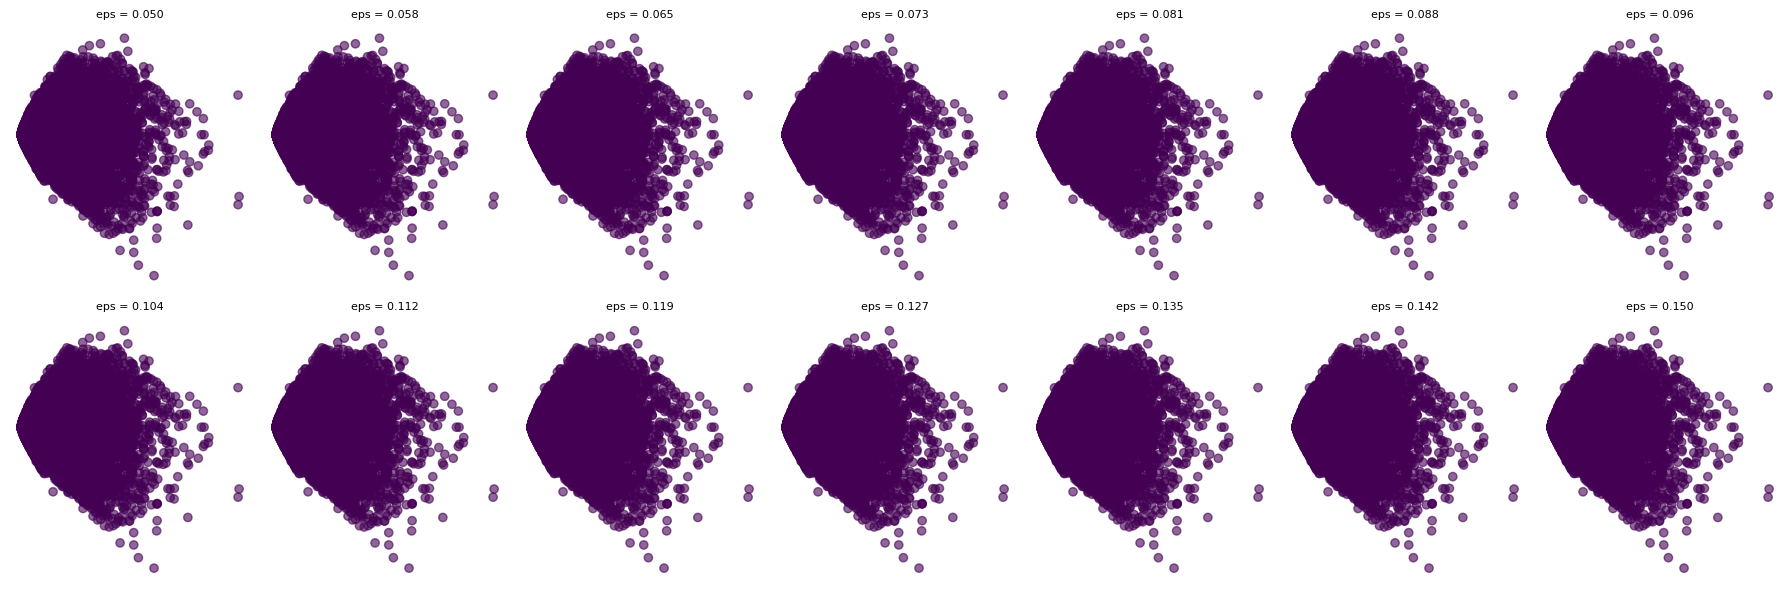

In [ ]:
# Convertir en matrice dense pour DBSCAN
dense_matrix = sparse_matrix_rep.toarray()  # DBSCAN nécessite un tableau dense si vous ne réduisez pas les dimensions
# dense_matrix= df[df['movieId'].isin(movieId_to_keep)]

from sklearn.decomposition import PCA
pca = PCA(n_components=30)  # Réduire à 2 dimensions pour la visualisation
reduced_data = pca.fit_transform(dense_matrix)
reduced_data = reduced_data[:,1:]

# Liste des eps
eps_list = np.linspace(0.05, 0.15, 14)

# Préparer les dimensions pour l'affichage
COLUMNS = 7
ROWS = math.ceil(len(eps_list) / COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(18, 6), sharey=True, sharex=True)

# Boucle sur chaque valeur de eps
for i in range(len(eps_list)):
    eps = eps_list[i]
    current_column = i % COLUMNS
    current_row = i // COLUMNS
    
    ax = axs[current_row, current_column]
    
    # Appliquer DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(reduced_data)  # Appliquer DBSCAN directement sur les données d'origine
    
    # Visualisation : utiliser uniquement deux dimensions pour scatter
    if reduced_data.shape[1] >= 2:
        ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.6)
    else:
        ax.text(0.5, 0.5, "Insufficient dims", ha="center", va="center")
    ax.set_title(f"eps = {eps:.3f}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()